<div align="right">
    **Автор:** 
    <br>Артём Трофимов (Artyom Trofimov)
    <br><br>**Дата:**
    <br>29.06.2018г. 
</div>

## <center>Идентификация интернет-пользователей</center>

Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика - такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину восстановить доступ к почте с помощью SMS-кода.

<img src="user_identification.png" width="300" align="center"/>

## 1. Цели и задачи проекта

Мы будем решать похожую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

### Исходные данные

Источник исходных данных - [статья "A Tool for Classification of Sequential Data"](http://ceur-ws.org/Vol-1703/paper12.pdf). 

Описание: имеются данные с прокси-серверов Университета Блеза Паскаля в виде csv-файлов следующего формата:
<br><br><center>*ID пользователя, timestamp, посещенный веб-сайт*</center>

### Данные для проекта

В проекте используются преобразованные исходные данные из [учебного соревнования на платформе Kaggle](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2):

**1. train_sessions.csv**
* Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем **site_dic.pkl**)
* Признаки time_j – время посещения сайтов site_j
* Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

**2. test_sessions.csv**
<br>
Те же самые признаки, за исключением _target_

### Задача
<br>Нужно создать алгоритм (модель), который будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или кто-то другой (например, взломщик).

Иными словами, **необходимо решить задачу классификации**.

### Методика измерения качества

**Целевая метрика - ROC AUC** - area under ROC curve. Напомним, что метрика ROC AUC - это площадь под кривой зависимости True Positive Rate от False Positive Rate. В зависимости от выбранного нами treshold на этой кривой мы будем получать то или иное значение точности при соответствующем значении полноты. [ROC AUC - пример описания](https://habrahabr.ru/post/228963/). 

Качество решения будем оценивать по публичному лидерборду (Public LB) соревнования.

Успешным будем считать решение строго больше **ROC AUC = 0.92784** (бенчмарк _Logit +3 features_):

<img src="Logit_plus_3_features.png" align="center"/>

## Загрузка данных

Импортируем библиотеки, которые будут использоваться при реализации проекта:

In [166]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt

from pylab import rcParams

import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse import hstack

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve

Считаем данные из файла *train_sessions.csv* в датафрейм **train_df**, а из *test_sessions.csv* - в **test_df**. 

В качестве индекса укажем столбец **\['session_id'\]**:

In [60]:
train_df = pd.read_csv('../data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('../data/test_sessions.csv', index_col='session_id')

Отсортируем данные по времени начала сессии _time1_:

In [61]:
train_df = train_df.sort_values(by='time1')

Выведем первые 5 записей обучающей выборки - датафрейма **train_df**:

In [62]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Выведем первые 5 записей тестовой выборки - датафрейма **test_df**:

In [63]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


Признаки в обучающей выборке:

* *site1* – индекс первого сайта в сессии
* *time1* – время посещения первого сайта в сессии
* ...
* *site10* – индекс 10-го сайта в сессии
* *time10* – время посещения 10-го сайта в сессии
* *user_id* – id пользователя

Сессии пользователей выделены так, что они не могут быть длинее 30 минут или 10 сайтов. То есть сессия считается оконченной или когда пользователь посетил 10 сайтов подряд, или когда сессия заняла по времени более получаса. Если в сессии меньше 10 сайтов, значит, в данных появляются пропуски - значения признаков равны **NaN** (not a number).

## 2. Первичный анализ признаков

**2.1.** Информация о признаках в обучающей и тестовой выборках:

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21669 to 204762
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


* Индексы сайтов - в формате float64. Привести к целочисленному формату int64
* И в обучающей, и в тестовой выборках много пропусков - нужно обработать
* Временные признаки нужно привести к формату datetime

**2.2.** Сколько сессий в обучающей выборке принадлежит Элис?

In [69]:
print('{} сессий обучающей выборки принадлежит Элис'.format(train_df['target'].value_counts()[1]))
print('{} сессий обучающей выборки принадлежит Элис'.format(train_df['target'].value_counts()[0]))
print('Доля сессий Элис: {0}%'.format(round(100 * train_df['target'].value_counts()[1] / train_df.shape[0], 2)))

2297 сессий обучающей выборки принадлежит Элис
251264 сессий обучающей выборки принадлежит Элис
Доля сессий Элис: 0.91%


* **Дисбаланс классов!**

## 3. Предобработка данных

Заполняем пропуски нулевыми значениями и приводим индексы сайтов к формату int64

In [113]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(int)
test_df[sites] = test_df[sites].fillna(0).astype(int)

times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].fillna(0)
test_df[times] = test_df[times].fillna(0)

Приводим признаки _time1, ... , time10_ к формату datetime:

In [114]:
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

Статистика признаков в обучающей и тестовой выборках после предобработки данных:

In [115]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21669 to 204762
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     253561 non-null int64
time2     253561 non-null datetime64[ns]
site3     253561 non-null int64
time3     253561 non-null datetime64[ns]
site4     253561 non-null int64
time4     253561 non-null datetime64[ns]
site5     253561 non-null int64
time5     253561 non-null datetime64[ns]
site6     253561 non-null int64
time6     253561 non-null datetime64[ns]
site7     253561 non-null int64
time7     253561 non-null datetime64[ns]
site8     253561 non-null int64
time8     253561 non-null datetime64[ns]
site9     253561 non-null int64
time9     253561 non-null datetime64[ns]
site10    253561 non-null int64
time10    253561 non-null datetime64[ns]
target    253561 non-null int64
dtypes: datetime64[ns](10), int64(11)
memory usage: 52.6 MB


In [116]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     82797 non-null int64
time2     82797 non-null datetime64[ns]
site3     82797 non-null int64
time3     82797 non-null datetime64[ns]
site4     82797 non-null int64
time4     82797 non-null datetime64[ns]
site5     82797 non-null int64
time5     82797 non-null datetime64[ns]
site6     82797 non-null int64
time6     82797 non-null datetime64[ns]
site7     82797 non-null int64
time7     82797 non-null datetime64[ns]
site8     82797 non-null int64
time8     82797 non-null datetime64[ns]
site9     82797 non-null int64
time9     82797 non-null datetime64[ns]
site10    82797 non-null int64
time10    82797 non-null datetime64[ns]
dtypes: datetime64[ns](10), int64(10)
memory usage: 15.8 MB


**Для обеих выборок:**
* Пропуски в данных отсутствуют
* Данные приведены к формату, необходимому для последующего анализа

## 4. Визуальный анализ данных

In [75]:
rcParams['figure.figsize'] = 10, 5

**3.1.** Распределение целевого признака в обучающей выборке

Text(0,0.5,'Кол-во')

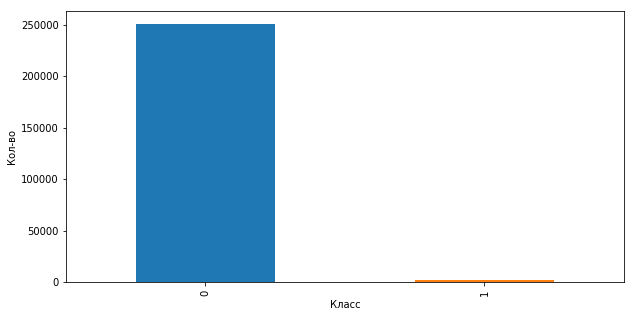

In [76]:
train_df['target'].value_counts().plot(kind='bar', label='target');
plt.xlabel('Класс')
plt.ylabel('Кол-во')

**3.2.** Распределение сессий по часу начала (_time1_)

#### Обучающая выборка

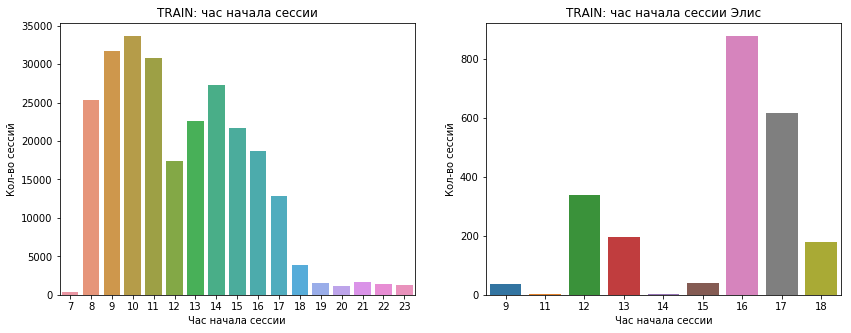

In [102]:
rcParams['figure.figsize'] = 12, 8

_, axes = plt.subplots(1, 2, figsize=(14,5))
sns.countplot(x=train_df['time1'].apply(lambda x: x.hour), data=train_df, ax=axes[0])

tmp_df = train_df[train_df.target==1]
sns.countplot(x=tmp_df['time1'].apply(lambda x: x.hour), data=tmp_df, ax=axes[1])


axes[0].set(xlabel='Час начала сессии', ylabel='Кол-во сессий', title='TRAIN: час начала сессии')
axes[1].set(xlabel='Час начала сессии', ylabel='Кол-во сессий', title='TRAIN: час начала сессии Элис');

#### Тестовая выборка

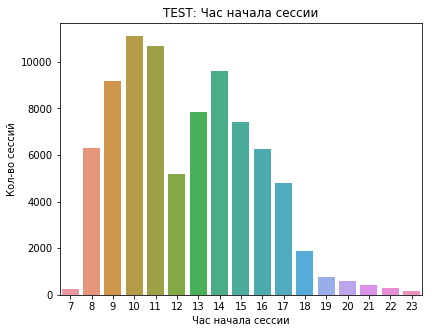

In [107]:
rcParams['figure.figsize'] = 6.5, 5
sns.countplot(x=test_df['time1'].apply(lambda x: x.hour), data=test_df)
plt.title('TEST: Час начала сессии')
plt.xlabel('Час начала сессии')
plt.ylabel('Кол-во сессий');

* Почасовое распределение в тестовой выборке соответствует распределению в тренировочной выборке
* Для Элис характерное время начала сессии: в 12 и 13 ч (обеденное время) и в 16, 17, 18 ч (конец рабочего дня)

**3.3.** Распределение сессий по дням

#### Обучающая выборка

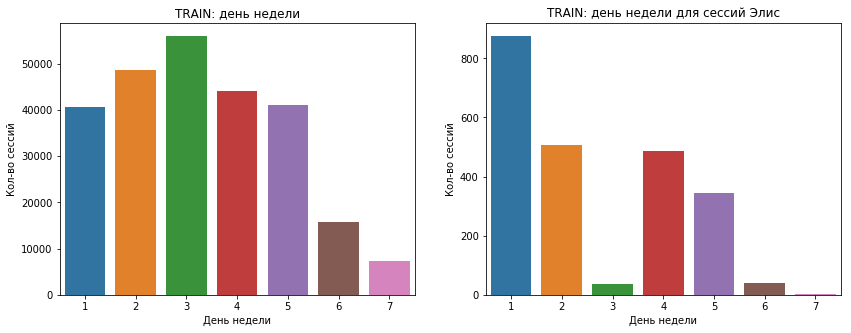

In [119]:
rcParams['figure.figsize'] = 12, 8

_, axes = plt.subplots(1, 2, figsize=(14,5))
sns.countplot(x=train_df['time1'].apply(lambda x: x.weekday() + 1), data=train_df, ax=axes[0])

tmp_df = train_df[train_df.target==1]
sns.countplot(x=tmp_df['time1'].apply(lambda x: x.weekday() + 1), data=tmp_df, ax=axes[1])


axes[0].set(xlabel='День недели', ylabel='Кол-во сессий', title='TRAIN: день недели')
axes[1].set(xlabel='День недели', ylabel='Кол-во сессий', title='TRAIN: день недели для сессий Элис');

#### Тестовая выборка

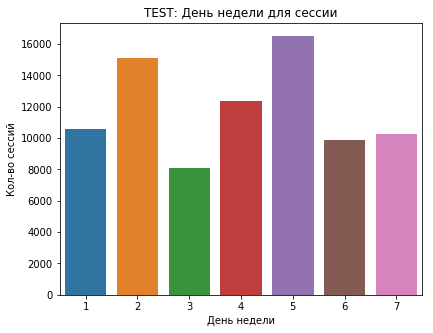

In [120]:
rcParams['figure.figsize'] = 6.5, 5
sns.countplot(x=test_df['time1'].apply(lambda x: x.weekday() + 1), data=test_df)
plt.title('TEST: День недели для сессии')
plt.xlabel('День недели')
plt.ylabel('Кол-во сессий');

* Распределение по дням в тестовой выборке более равномерное и отличается от распределения в обучающей выборке
* Элис наиболее активна в понедельник (пик активности), вторник, четверг и пятницу

### По результатам первичного визуального анализа можно сделать вывод о целесообразности использования _time1, ... , time10_ для создания новых признаков.

## 5. Создание новых признаков

Объединим обучающую и тестововую выборки. Предварительно сохраним значения целевой переменной из обучающей выборки: 

In [121]:
y_train = train_df['target']

In [122]:
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

Инициализируем переменную для хранения индекса для разделения объединенного датафрейма после создания новых признаков:

In [123]:
idx_split = train_df.shape[0]

Создадим вспомогательный датафрейм без временных признаков:

In [125]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


### 5.1. Приведение данных о сайтах в сессии к разреженному виду

Сессия - это последовательность индексов сайтов, но текущее представление данных не подходит для линейных моделей.

Приведем датафрейм **full_sites** к разреженному виду: в новом датафрейме **full_sites_sparse** каждому сайту будет соответствовать отдельный столбец, значение которого будет равно количеству появлений сайта в сессии:

In [130]:
# Последовательность индексов
sites_flatten = full_sites.values.flatten()

# Разреженная матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

Размерность разреженной матрицы:

In [129]:
full_sites_sparse.shape

(336358, 48371)

Получено 48371 признаков для новой обучающей и тестовой выборок:

In [139]:
X_train = full_sites_sparse[:idx_split, :]
X_test = full_sites_sparse[idx_split:,:]

### Датафреймы для новых признаков

In [140]:
new_feat_train = pd.DataFrame(index = train_df.index)
new_feat_test = pd.DataFrame(index = test_df.index)

### StandardScaler() ля масштабирования новых признаков

In [141]:
scaler = StandardScaler()

### 5.2. Признак year_month

Синтетический неинтерпретирумый признак, в основе которого - год и месяц начала сессии

In [142]:
new_feat_train['year_month'] = train_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)
new_feat_test['year_month'] = test_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)

Нормированный:

In [143]:
scaler.fit(new_feat_train['year_month'].values.reshape(-1, 1))
new_feat_train['year_month_scaled'] = scaler.transform(new_feat_train['year_month'].values.reshape(-1, 1))
new_feat_test['year_month_scaled'] = scaler.transform(new_feat_test['year_month'].values.reshape(-1, 1))

### 5.3. Признак starting_hour

Час начала сессии

In [144]:
new_feat_train['starting_hour'] = train_df['time1'].apply(lambda ts: ts.hour)
new_feat_test['starting_hour'] = test_df['time1'].apply(lambda ts: ts.hour)

Нормированный:

In [145]:
scaler.fit(new_feat_train['starting_hour'].values.reshape(-1, 1))
new_feat_train['starting_hour_scaled'] = scaler.transform(new_feat_train['starting_hour'].values.reshape(-1, 1))
new_feat_test['starting_hour_scaled'] = scaler.transform(new_feat_test['starting_hour'].values.reshape(-1, 1))

### 5.4. Признаки morning, day, evening, night

Бинарные принаки: 
* 1 - если сессия начинается в период с N до M часов
* 0 - остальное время

In [146]:
new_feat_train['morning'] = new_feat_train['starting_hour'].apply(lambda m: 1 if (m <= 11 and m > 8) else 0)
new_feat_test['morning'] = new_feat_test['starting_hour'].apply(lambda m: 1 if (m <= 11 and m > 8) else 0)

In [147]:
new_feat_train['day'] = new_feat_train['starting_hour'].apply(lambda d: 1 if (d <= 17 and d > 11) else 0)
new_feat_test['day'] = new_feat_test['starting_hour'].apply(lambda d: 1 if (d <= 17 and d > 11) else 0)

In [148]:
new_feat_train['evening'] = new_feat_train['starting_hour'].apply(lambda e: 1 if (e <= 23 and e > 17) else 0)
new_feat_test['evening'] = new_feat_test['starting_hour'].apply(lambda e: 1 if (e <= 23 and e > 17) else 0)

In [149]:
new_feat_train['night'] = new_feat_train['starting_hour'].apply(lambda n: 1 if (n <= 8 and n > 0) else 0)
new_feat_test['night'] = new_feat_test['starting_hour'].apply(lambda n: 1 if (n <= 8 and n > 0) else 0)

### 5.5. Признак start_month

Месяц в котором была сессия

In [150]:
new_feat_train['start_month'] = train_df['time1'].apply(lambda ts: ts.month)
new_feat_test['start_month'] = test_df['time1'].apply(lambda ts: ts.month)

Нормированный:

In [151]:
scaler.fit(new_feat_train['start_month'].values.reshape(-1, 1))

new_feat_train['start_month_scaled'] = scaler.transform(new_feat_train['start_month'].values.reshape(-1, 1))
new_feat_test['start_month_scaled'] = scaler.transform(new_feat_test['start_month'].values.reshape(-1, 1))

### 5.6. Признак duration

Длительность сессии в секундах

In [152]:
new_feat_train['time_min'] = train_df[times].min(axis=1)
new_feat_train['time_max'] = train_df[times].max(axis=1)

new_feat_train['duration'] = (new_feat_train['time_max'] - new_feat_train['time_min']) / np.timedelta64(1, 's')

In [153]:
new_feat_test['time_min'] = test_df[times].min(axis=1)
new_feat_test['time_max'] = test_df[times].max(axis=1)

new_feat_test['duration'] = (new_feat_test['time_max'] - new_feat_test['time_min']) / np.timedelta64(1, 's')

Нормализация:

In [154]:
scaler.fit(new_feat_train['duration'].values.reshape(-1, 1))

new_feat_train['duration_scaled'] = scaler.transform(new_feat_train['duration'].values.reshape(-1, 1))
new_feat_test['duration_scaled'] = scaler.transform(new_feat_test['duration'].values.reshape(-1, 1))

### 5.7. Признак weekday

День недели, когда была сессия

In [155]:
new_feat_train['weekday'] = new_feat_train['time_min'].apply(lambda ts: ts.weekday()+1)
new_feat_test['weekday'] = new_feat_test['time_min'].apply(lambda ts: ts.weekday()+1)

Нормализация:

In [156]:
scaler.fit(new_feat_train['weekday'].values.reshape(-1, 1))
new_feat_train['weekday_scaled'] = scaler.transform(new_feat_train['weekday'].values.reshape(-1, 1))
new_feat_test['weekday_scaled'] = scaler.transform(new_feat_test['weekday'].values.reshape(-1, 1))

### 5.7. Признак is_weekend

Была сессия в выхожной день (6 - Сб, 7 - Вс) или нет.

In [157]:
new_feat_train['is_weekend'] = new_feat_train['weekday'].apply(lambda d: 1 if (d == 6 or d == 7) else 0)
new_feat_test['is_weekend'] = new_feat_test['weekday'].apply(lambda d: 1 if (d == 6 or d == 7) else 0)

### 5.8. Объединим разреженные матрицы, бинарные и нормализованные признаки

In [158]:
X_train = csr_matrix(hstack([X_train, 
                             new_feat_train[['year_month_scaled', 'start_month_scaled', 'duration_scaled', 
                                             'weekday_scaled', 'is_weekend', 
                                             'starting_hour_scaled', 'morning', 'day', 'evening', 'night']].values]))
X_test = csr_matrix(hstack([X_test, 
                            new_feat_test[['year_month_scaled', 'start_month_scaled', 'duration_scaled', 
                                           'weekday_scaled', 'is_weekend', 
                                           'starting_hour_scaled', 'morning', 'day', 'evening', 'night']].values]))

In [160]:
X_train.shape, X_test.shape

((253561, 48381), (82797, 48381))

## 6. Выбор модели, кросс-валидация, построение кривых валидации и обучения

Вспомогательные функции для отрисовки кривых валидации и обучения

In [198]:
def plot_validation_curves(param_values, grid_cv_results_):
    plt.figure(figsize=(10, 5))
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [194]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

### Выбор алгоритма

Учитывая большую размерность выборки, будем сравнивать 2 линейных модели: LogisticRegression() и SGDClassifier()

In [168]:
logreg = LogisticRegression(C = 1.0, random_state = 42, n_jobs = -1)
sgd_clf = SGDClassifier(loss = 'log', random_state = 42, n_jobs = -1)

### Кросс-валидация (CV)

Параметры кросс-валидации:
* 5 фолдов
* Пермешивать данные
* random_state = 42 для воспроизводимости результатов

In [167]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 6.1. Обучение SGDClassifier и LogisticRegression

In [172]:
print('SGDClassifier, значение ROC AUC: ', 
      round(cross_val_score(sgd_clf, X_train, y_train, cv=skf, scoring='roc_auc').mean(),3))

SGDClassifier, значение ROC AUC:  0.961


In [173]:
print('LogisticRegression, значение ROC AUC: ', 
      round(cross_val_score(logreg, X_train, y_train, cv=skf, scoring='roc_auc').mean(),3))

Значение ROC AUC для LogisticRegression:  0.981


### 6.2. Подбор гиперпараметров

Подбор гиперпараметров произведем с помощью **GridSearchCV**.

#### Для SGDClassifier

In [175]:
# Гиперпараметр alpha для SGDClassifier
sgd_params = {'alpha': np.linspace(0.00001, 0.0001, 10)}

In [176]:
%%time
sgd_grid_searcher = GridSearchCV(sgd_clf, sgd_params, cv=skf, scoring='roc_auc', n_jobs=-1)
sgd_grid_searcher.fit(X_train, y_train)

CPU times: user 7.65 s, sys: 396 ms, total: 8.05 s
Wall time: 3min 9s


* Лучший результат:

In [188]:
print('SGDClassifier, лучшее значение ROC AUC: {}'.format(round(sgd_grid_searcher.best_score_, 4)))
print('Параметр alpha: {}'.format('%.7f' % sgd_grid_searcher.best_params_['alpha']))

SGDClassifier, лучшее значение ROC AUC: 0.9703
Параметр alpha: 0.0000200


* Кривые валидации:

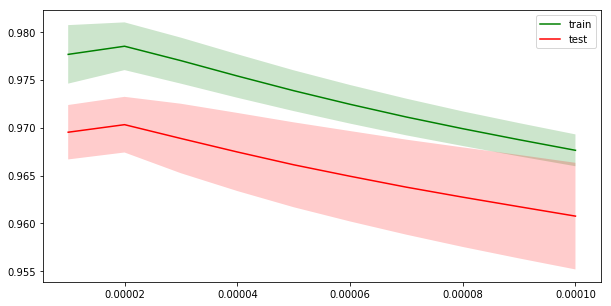

In [199]:
plot_validation_curves(sgd_params['alpha'], sgd_grid_searcher.cv_results_)

#### Для LogisticRegression

In [200]:
# Гиперпараметр C
C_values = np.linspace(0.1, 5, 10)

In [201]:
%%time
logreg_grid_searcher = LogisticRegressionCV(Cs = C_values, cv=skf, random_state = 42, scoring='roc_auc', n_jobs = -1)
logreg_grid_searcher.fit(X_train, y_train)

CPU times: user 6.98 s, sys: 883 ms, total: 7.87 s
Wall time: 2min 31s


In [203]:
logreg_mean_cv_scores = np.zeros(len(C_values))

for i in logreg_grid_searcher.scores_[1]: 
    logreg_mean_cv_scores  += np.array(i)          

logreg_mean_cv_scores = logreg_mean_cv_scores / 5            

logreg_mean_cv_scores

array([0.96872442, 0.97956323, 0.98092442, 0.98139642, 0.98161233,
       0.98172251, 0.98178031, 0.98180558, 0.98180673, 0.98179896])

* Лучший результат:

In [206]:
print('LogisticRegression, лучшее значение ROC AUC: {}'.format('%.6f' % logreg_mean_cv_scores.max()))
print('Параметр C: {}'.format('%.3f' % logreg_grid_searcher.Cs_[logreg_mean_cv_scores.argmax()]))

LogisticRegression, лучшее значение ROC AUC: 0.981807
Параметр C: 4.456


* График зависимости ROC AUC на кросс-валидации от C:

Text(0,0.5,'ROC AUC')

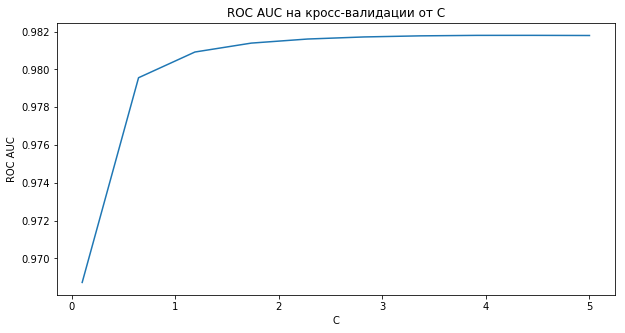

In [210]:
plt.figure(figsize=(10, 5))
plt.plot(C_values, logreg_mean_cv_scores)
plt.title('ROC AUC на кросс-валидации от C')
plt.xlabel('С')
plt.ylabel('ROC AUC')

## 7. Оценка модели с описанием выбранной метрики

Лучшее качество на кросс-валидации показал алгоритм LogisticRegression. 

Обучим LogisticRegression с оптимальным гиперпараметром C, сохраним результат предсказаний в файл и проверим результат на публичном лидерборде Kaggle.

Для записи в файл будет использоваться вспомогательная функция:

In [211]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [212]:
logreg_final = LogisticRegression(C = logreg_grid_searcher.Cs_[logreg_mean_cv_scores.argmax()], 
                                  random_state = 42, n_jobs = -1)

In [213]:
y_pred = logreg_final.fit(X_train, y_train).predict_proba(X_test)[:,1]

In [214]:
write_to_submission_file(y_pred, 'logreg_submit.csv')

### Результат на Kaggle

Значение ROC AUC на публичной части тестовой выборки составило 0.93110.

<img src="report.png" align="center"/>

## 8. Выводы

Разработанная модель удовлетворяет изначально обозначенному критерию успешности: **0.93110 > 0.92784** _Logit + 3 features_

Модель может быть адаптирована для идентификации интернет-пользователей при условии совпадающего содержания и формата исходных данных.

### Пути улучшения модели

* Увеличение обучающей выборки
* Синтез дополнительных признаков
* Построить ансамбль моделей
* Применить стекинг
* Применить блендинг